In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from helperFunctions import createDataSet
import os

In [37]:
file_num = 1
DATA_PATH = "/Users/nathanhoffman/Library/Mobile Documents/com~apple~CloudDocs/UniBe/3. Semester/Data Driven Diabetes Management/DDDM-Project7/data/Ohio2020_processed/train"
files = os.listdir(DATA_PATH)
file = files[file_num]
train_set, scaler = createDataSet(os.path.join(DATA_PATH, file))

DATA_PATH = "/Users/nathanhoffman/Library/Mobile Documents/com~apple~CloudDocs/UniBe/3. Semester/Data Driven Diabetes Management/DDDM-Project7/data/Ohio2020_processed/test"
files = os.listdir(DATA_PATH)
file = files[file_num]
test_set, scaler = createDataSet(os.path.join(DATA_PATH, file), scaler=scaler)

print(f"Length of train set: {len(train_set)}")
print(f"Length of test set: {len(test_set)}")
print(train_set[0])

Length of train set: 18
Length of test set: 25
          cbg    finger  carbInput  bolus  finger_extended  minutesAfterMeal  \
0   -0.328767 -0.021739   0.000000    0.0        -0.021739          0.611111   
5   -0.369863  0.000000   0.000000    0.0        -0.021739          0.666667   
10  -0.410959  0.000000   0.000000    0.0        -0.021739          0.722222   
15  -0.424658  0.000000   0.000000    0.0        -0.021739          0.777778   
20  -0.479452  0.000000   0.000000    0.0        -0.021739          0.833333   
25  -0.547945  0.000000   0.000000    0.0        -0.021739          0.888889   
30  -0.589041  0.000000  -0.444444    0.0        -0.021739         -0.944444   
35  -0.657534  0.000000   0.000000    0.0        -0.021739         -0.888889   
40  -0.698630  0.000000   0.000000    0.0        -0.021739         -0.833333   
45  -0.726027  0.000000   0.000000    0.0        -0.021739         -0.777778   
50  -0.726027  0.000000   0.000000    0.0        -0.021739         -0.722

In [30]:
def train_model(model, data, i = 0):
    # Seperating X and y
    X = data.drop(["cbg"], axis=1)
    random.seed(42)
    X["glucose_lag_1"]  = X["glucose_lag_1"] * random.uniform(0.75, 1.25)
    X["glucose_lag_2"]  = X["glucose_lag_2"] * random.uniform(0.75, 1.25)
    y_true = data["cbg"]


    param = {'kernel' : ('linear', 'poly', 'rbf', 'sigmoid'),
             'C' : [1,5,10],
             'degree' : [3,8],
             'coef0' : [0.01,10,0.5],
             'gamma' : ['scale', 'auto']}

    clf = GridSearchCV(estimator = model,
                        param_grid = param, 
                        cv = 3, 
                        n_jobs = -1, 
                        verbose = 2)
    
    # Train the linear regression model on the scaled data
    clf.fit(X, y_true)
    
    # Make predictions
    y_pred = clf.predict(X)

    # y_preds = []

    # # Perform iterative predictions
    # for i in range(len(X)):
    #     # Make a prediction for the current row
    #     model.fit(X.iloc[i:i+1, :], y_true[i:i+1])
    #     y_pred = model.predict(X.iloc[i, :].values.reshape(1, -1))[0]
    #     y_preds.append(y_pred)
        
    #     # Store the predicted cbg
    #     # X.loc[X.index[i], 'predicted_cbg'] = y_pred
        
    #     # Update glucose_lag_1 and glucose_lag_2 for the next row if it's within bounds
    #     if i + 1 < len(X):
    #         X.loc[X.index[i + 1], 'glucose_lag_2'] = X.loc[X.index[i], 'glucose_lag_1']
    #         X.loc[X.index[i + 1], 'glucose_lag_1'] = y_pred

    # Inverse scaling
    # X = scaler.inverse_transform(X)
    # y_true -= scaler.min_[2]
    # y_true /= scaler.scale_[2]
    # y_pred -= scaler.min_[2]
    # y_pred /= scaler.scale_[2]
    # print(len(y_preds))
    # y_preds = np.array(y_preds).reshape(1, -1)
    # print(y_true)

    fig, axs = plt.subplots(1, 2, figsize=(20, 5))
    axs[0].plot(X.index, y_true, label="Ground Truth")
    axs[0].plot(X.index,y_pred, label="Prediction")
    # axs[0].plot(carbInput.index, carbInput["carbInput"], "ro")
    # axs2 = axs[0].twinx()
    # axs2.plot(carbInput.index, carbInput["carbInput"], "ro", label="Carb intake")
    # axs[1].bar(X.columns.values, model.coef_)
    # plt.setp( axs[1].xaxis.get_majorticklabels(), rotation=70 )
    
    # plt.tight_layout()
    # axs[0].legend(loc="upper center")
    # plt.title(f"Number in List: {i}")

    return  clf.best_estimator_

In [31]:
def test_model(model, data, scaler):
    """
    Test the linear regression model with simulated iterative predictions.
    :param model: Trained linear regression model
    :param X_test: Test set features DataFrame
    :param y_test: Actual target values for the test set
    :return: DataFrame with simulated predictions and mean squared error
    """


    def invTransform(scaler, data, colName, colNames):
        # - scaler   = the scaler object (it needs an inverse_transform method)
        # - data     = the data to be inverse transformed as a Series, ndarray, ... 
        #              (a 1d object you can assign to a df column)
        # - ftName   = the name of the column to which the data belongs
        # - colNames = all column names of the data on which scaler was fit 
        #              (necessary because scaler will only accept a df of the same shape as the one it was fit on)
        dummy = pd.DataFrame(np.zeros((len(data), len(colNames))), columns=colNames)
        dummy[colName] = data
        dummy = pd.DataFrame(scaler.inverse_transform(dummy), columns=colNames)
        return dummy[colName].values

    # Seperating X and y
    X = data.drop(["cbg"], axis=1)
    y_true = data["cbg"]
    y_preds = []

    # Perform iterative predictions
    for i in range(len(X)):
        # Make a prediction for the current row
        y_pred = model.predict(X.iloc[i, :].values.reshape(1, -1))[0]
        y_preds.append(y_pred)
        
        # Update glucose_lag_1 and glucose_lag_2 for the next row if it's within bounds
        if i % 2 == 0:
            continue


        if i + 1 < len(X):
            X.loc[X.index[i + 1], 'glucose_lag_2'] = X.loc[X.index[i + 1], 'glucose_lag_1']
            X.loc[X.index[i + 1], 'glucose_lag_1'] = y_pred

    fig, axs = plt.subplots(1, 2, figsize=(20, 5))
    axs[0].plot(X.index, y_true, label="Ground Truth")
    axs[0].plot(X.index, y_preds, label="Prediction")
    # axs[0].plot(X.index, invTransform(scaler, y_true, "cbg", data.columns.values), label="Ground Truth")
    # axs[0].plot(X.index,invTransform(scaler, y_preds, "cbg", data.columns.values), label="Prediction")
    # axs[0].plot(carbInput.index, carbInput["carbInput"], "ro")
    # axs2 = axs[0].twinx()
    # axs2.plot(carbInput.index, carbInput["carbInput"], "ro", label="Carb intake")
    # y_preds = np.array(y_preds).reshape(1, -1)
    squared_error = (y_true - y_pred) ** 2
    axs[1].plot(X.index, squared_error, label="RMSE")
    # plt.setp( axs[1].xaxis.get_majorticklabels(), rotation=45 )
    plt.tight_layout()
    axs[0].legend(loc="upper center")
    # Calculate the Mean Squared Error between simulated predictions and actual values
    # mse = mean_squared_error(y_true, df_simulation['predicted_cbg'].dropna())
    # print(f'Mean Squared Error on simulated test set: {mse}')

    # return df_simulation[['glucose_lag_1', 'glucose_lag_2', 'predicted_cbg']], mse

Fitting 3 folds for each of 144 candidates, totalling 432 fits
[CV] END C=1, coef0=0.01, degree=3, gamma=scale, kernel=linear; total time=   0.0s
[CV] END C=1, coef0=0.01, degree=3, gamma=scale, kernel=linear; total time=   0.0s
[CV] END C=1, coef0=0.01, degree=3, gamma=scale, kernel=linear; total time=   0.0s
[CV] END C=1, coef0=0.01, degree=3, gamma=scale, kernel=poly; total time=   0.0s
[CV] END C=1, coef0=0.01, degree=3, gamma=scale, kernel=poly; total time=   0.0s
[CV] END C=1, coef0=0.01, degree=3, gamma=scale, kernel=poly; total time=   0.0s
[CV] END .C=1, coef0=0.01, degree=3, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END .C=1, coef0=0.01, degree=3, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END .C=1, coef0=0.01, degree=3, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END C=1, coef0=0.01, degree=3, gamma=auto, kernel=linear; total time=   0.0s
[CV] END C=1, coef0=0.01, degree=3, gamma=scale, kernel=sigmoid; total time=   0.0s
[CV] END C=1, coef0=0.01, degree=3, 

/opt/homebrew/Caskroom/miniforge/base/envs/py312/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
/opt/homebrew/Caskroom/miniforge/base/envs/py312/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


[CV] END ..C=1, coef0=10, degree=3, gamma=scale, kernel=poly; total time=   0.0s
[CV] END ...C=1, coef0=10, degree=3, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END .C=1, coef0=10, degree=3, gamma=auto, kernel=linear; total time=   0.0s
[CV] END ..C=1, coef0=10, degree=3, gamma=scale, kernel=poly; total time=   0.0s
[CV] END C=1, coef0=10, degree=3, gamma=scale, kernel=linear; total time=   0.0s
[CV] END C=1, coef0=10, degree=3, gamma=scale, kernel=sigmoid; total time=   0.0s
[CV] END ...C=1, coef0=10, degree=3, gamma=auto, kernel=poly; total time=   0.0s
[CV] END .C=1, coef0=10, degree=3, gamma=auto, kernel=linear; total time=   0.0s
[CV] END C=1, coef0=10, degree=3, gamma=scale, kernel=linear; total time=   0.0s
[CV] END C=1, coef0=10, degree=3, gamma=scale, kernel=sigmoid; total time=   0.0s
[CV] END ...C=1, coef0=10, degree=3, gamma=auto, kernel=poly; total time=   0.0s
[CV] END .C=1, coef0=10, degree=3, gamma=auto, kernel=linear; total time=   0.0s
[CV] END C=1, coef0=10, de

/opt/homebrew/Caskroom/miniforge/base/envs/py312/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
/opt/homebrew/Caskroom/miniforge/base/envs/py312/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


[CV] END C=10, coef0=0.01, degree=8, gamma=scale, kernel=sigmoid; total time=   0.0s
[CV] END .C=5, coef0=0.5, degree=3, gamma=scale, kernel=poly; total time=   0.0s
[CV] END C=10, coef0=0.01, degree=3, gamma=scale, kernel=sigmoid; total time=   0.0s
[CV] END ...C=10, coef0=10, degree=3, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END ...C=5, coef0=0.5, degree=8, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END C=10, coef0=0.01, degree=8, gamma=scale, kernel=sigmoid; total time=   0.0s
[CV] END C=10, coef0=0.01, degree=3, gamma=scale, kernel=sigmoid; total time=   0.0s
[CV] END .C=5, coef0=0.5, degree=3, gamma=scale, kernel=poly; total time=   0.0s
[CV] END .C=5, coef0=0.5, degree=8, gamma=scale, kernel=poly; total time=   0.0s
[CV] END ...C=10, coef0=10, degree=3, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END C=10, coef0=0.01, degree=8, gamma=scale, kernel=linear; total time=   0.0s
[CV] END C=10, coef0=0.01, degree=8, gamma=auto, kernel=linear; total time=   0.0s
[CV] EN

/opt/homebrew/Caskroom/miniforge/base/envs/py312/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
/opt/homebrew/Caskroom/miniforge/base/envs/py312/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


[CV] END ....C=1, coef0=10, degree=3, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END C=1, coef0=10, degree=3, gamma=auto, kernel=sigmoid; total time=   0.0s
[CV] END C=1, coef0=10, degree=8, gamma=scale, kernel=linear; total time=   0.0s
[CV] END ..C=1, coef0=10, degree=8, gamma=scale, kernel=poly; total time=   0.0s
[CV] END ...C=1, coef0=10, degree=3, gamma=auto, kernel=poly; total time=   0.0s
[CV] END C=1, coef0=10, degree=3, gamma=auto, kernel=sigmoid; total time=   0.0s
[CV] END ...C=1, coef0=10, degree=8, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ...C=1, coef0=10, degree=8, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END C=1, coef0=10, degree=8, gamma=scale, kernel=linear; total time=   0.0s
[CV] END .C=1, coef0=10, degree=8, gamma=auto, kernel=linear; total time=   0.0s
[CV] END ...C=1, coef0=10, degree=8, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END C=1, coef0=10, degree=8, gamma=scale, kernel=sigmoid; total time=   0.0s
[CV] END ..C=1, coef0=10, d

/opt/homebrew/Caskroom/miniforge/base/envs/py312/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


[CV] END C=5, coef0=10, degree=8, gamma=auto, kernel=sigmoid; total time=   0.0s
[CV] END ...C=5, coef0=10, degree=8, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END C=5, coef0=10, degree=8, gamma=scale, kernel=sigmoid; total time=   0.0s
[CV] END C=5, coef0=0.5, degree=3, gamma=scale, kernel=linear; total time=   0.0s
[CV] END ..C=5, coef0=0.5, degree=3, gamma=auto, kernel=poly; total time=   0.0s
[CV] END ...C=5, coef0=10, degree=3, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ..C=5, coef0=0.5, degree=3, gamma=auto, kernel=poly; total time=   0.0s
[CV] END C=5, coef0=0.5, degree=3, gamma=scale, kernel=linear; total time=   0.0s
[CV] END ...C=5, coef0=10, degree=3, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END C=10, coef0=0.01, degree=3, gamma=scale, kernel=linear; total time=   0.0s
[CV] END ...C=5, coef0=0.5, degree=3, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END .C=5, coef0=10, degree=8, gamma=auto, kernel=linear; total time=   0.0s
[CV] END ..C=5, coef0=

/opt/homebrew/Caskroom/miniforge/base/envs/py312/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
/opt/homebrew/Caskroom/miniforge/base/envs/py312/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
/var/folders/50/40hhzd5j4_5fr1sv5_b997z00000gn/T/ipykernel_17912/4230802579.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


[CV] END C=10, coef0=0.5, degree=8, gamma=scale, kernel=sigmoid; total time=   0.0s
[CV] END C=10, coef0=0.5, degree=8, gamma=scale, kernel=sigmoid; total time=   0.0s
[CV] END C=10, coef0=0.5, degree=8, gamma=auto, kernel=linear; total time=   0.0s
[CV] END C=10, coef0=0.5, degree=8, gamma=auto, kernel=linear; total time=   0.0s
[CV] END C=10, coef0=0.5, degree=8, gamma=auto, kernel=linear; total time=   0.0s
[CV] END .C=10, coef0=0.5, degree=8, gamma=auto, kernel=poly; total time=   0.0s
[CV] END .C=10, coef0=0.5, degree=8, gamma=auto, kernel=poly; total time=   0.0s
[CV] END .C=10, coef0=0.5, degree=8, gamma=auto, kernel=poly; total time=   0.0s
[CV] END ..C=10, coef0=0.5, degree=8, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END ..C=10, coef0=0.5, degree=8, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END ..C=10, coef0=0.5, degree=8, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END C=10, coef0=0.5, degree=8, gamma=auto, kernel=sigmoid; total time=   0.0s
[CV] END C=10, co

/opt/homebrew/Caskroom/miniforge/base/envs/py312/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
/opt/homebrew/Caskroom/miniforge/base/envs/py312/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


[CV] END ...C=1, coef0=10, degree=8, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END .C=1, coef0=10, degree=8, gamma=auto, kernel=linear; total time=   0.0s
[CV] END C=1, coef0=10, degree=3, gamma=auto, kernel=sigmoid; total time=   0.0s
[CV] END C=1, coef0=10, degree=8, gamma=scale, kernel=sigmoid; total time=   0.0s
[CV] END C=1, coef0=10, degree=8, gamma=scale, kernel=linear; total time=   0.0s
[CV] END .C=1, coef0=10, degree=8, gamma=auto, kernel=linear; total time=   0.0s
[CV] END C=1, coef0=10, degree=8, gamma=scale, kernel=sigmoid; total time=   0.0s
[CV] END ..C=1, coef0=10, degree=8, gamma=scale, kernel=poly; total time=   0.0s
[CV] END ...C=1, coef0=10, degree=8, gamma=auto, kernel=poly; total time=   0.0s
[CV] END C=1, coef0=10, degree=8, gamma=scale, kernel=sigmoid; total time=   0.0s
[CV] END ...C=1, coef0=10, degree=8, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END .C=1, coef0=10, degree=8, gamma=auto, kernel=linear; total time=   0.0s
[CV] END C=1, coef0=10, d

/opt/homebrew/Caskroom/miniforge/base/envs/py312/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
/opt/homebrew/Caskroom/miniforge/base/envs/py312/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


[CV] END ...C=5, coef0=0.5, degree=8, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END ..C=10, coef0=10, degree=8, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END C=10, coef0=0.01, degree=3, gamma=scale, kernel=sigmoid; total time=   0.0s
[CV] END C=10, coef0=0.01, degree=8, gamma=scale, kernel=linear; total time=   0.0s
[CV] END C=5, coef0=0.5, degree=8, gamma=auto, kernel=sigmoid; total time=   0.0s
[CV] END C=10, coef0=0.01, degree=3, gamma=scale, kernel=sigmoid; total time=   0.0s
[CV] END C=10, coef0=10, degree=8, gamma=scale, kernel=sigmoid; total time=   0.0s
[CV] END ...C=10, coef0=10, degree=3, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END C=10, coef0=0.01, degree=8, gamma=scale, kernel=linear; total time=   0.0s
[CV] END C=5, coef0=0.5, degree=8, gamma=auto, kernel=sigmoid; total time=   0.0s
[CV] END C=10, coef0=10, degree=3, gamma=scale, kernel=sigmoid; total time=   0.0s
[CV] END C=10, coef0=0.01, degree=3, gamma=auto, kernel=linear; total time=   0.0s
[CV] E

/opt/homebrew/Caskroom/miniforge/base/envs/py312/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
/opt/homebrew/Caskroom/miniforge/base/envs/py312/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


[CV] END C=1, coef0=0.5, degree=3, gamma=scale, kernel=linear; total time=   0.0s
[CV] END C=1, coef0=10, degree=8, gamma=auto, kernel=sigmoid; total time=   0.0s
[CV] END C=1, coef0=0.5, degree=3, gamma=auto, kernel=linear; total time=   0.0s
[CV] END .C=1, coef0=0.5, degree=3, gamma=scale, kernel=poly; total time=   0.0s
[CV] END C=1, coef0=10, degree=8, gamma=auto, kernel=sigmoid; total time=   0.0s
[CV] END C=1, coef0=0.5, degree=3, gamma=auto, kernel=linear; total time=   0.0s
[CV] END ..C=1, coef0=0.5, degree=3, gamma=auto, kernel=poly; total time=   0.0s
[CV] END ..C=1, coef0=0.5, degree=3, gamma=auto, kernel=poly; total time=   0.0s
[CV] END C=1, coef0=0.5, degree=8, gamma=scale, kernel=linear; total time=   0.0s
[CV] END C=1, coef0=10, degree=8, gamma=auto, kernel=sigmoid; total time=   0.0s
[CV] END ..C=1, coef0=0.5, degree=8, gamma=auto, kernel=poly; total time=   0.0s
[CV] END C=1, coef0=0.5, degree=8, gamma=scale, kernel=linear; total time=   0.0s
[CV] END C=5, coef0=0.01,

/opt/homebrew/Caskroom/miniforge/base/envs/py312/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
/opt/homebrew/Caskroom/miniforge/base/envs/py312/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


[CV] END C=10, coef0=0.5, degree=8, gamma=scale, kernel=poly; total time=   0.0s
[CV] END .C=10, coef0=0.5, degree=8, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END .C=10, coef0=0.5, degree=8, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END .C=10, coef0=0.5, degree=8, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END C=10, coef0=0.5, degree=8, gamma=scale, kernel=sigmoid; total time=   0.0s
[CV] END C=10, coef0=0.5, degree=8, gamma=scale, kernel=sigmoid; total time=   0.0s
[CV] END C=10, coef0=0.5, degree=8, gamma=scale, kernel=sigmoid; total time=   0.0s
[CV] END C=10, coef0=0.5, degree=8, gamma=auto, kernel=linear; total time=   0.0s
[CV] END C=10, coef0=0.5, degree=8, gamma=auto, kernel=linear; total time=   0.0s
[CV] END .C=10, coef0=0.5, degree=8, gamma=auto, kernel=poly; total time=   0.0s
[CV] END C=10, coef0=0.5, degree=8, gamma=auto, kernel=linear; total time=   0.0s
[CV] END ..C=10, coef0=0.5, degree=8, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END .C=10, 

<Figure size 640x480 with 0 Axes>

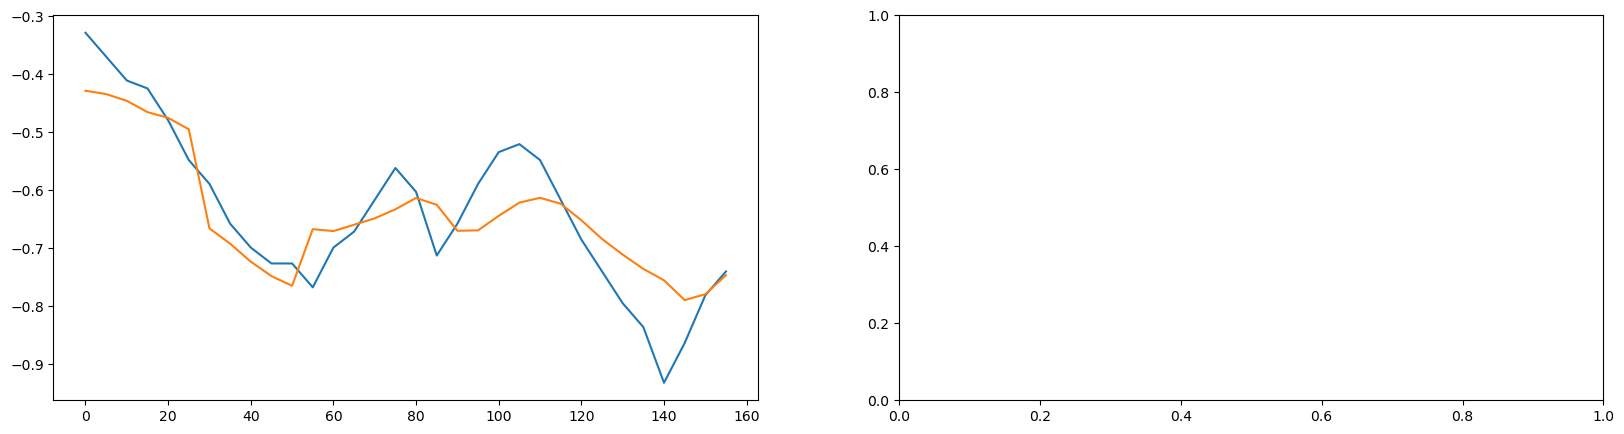

<Figure size 640x480 with 0 Axes>

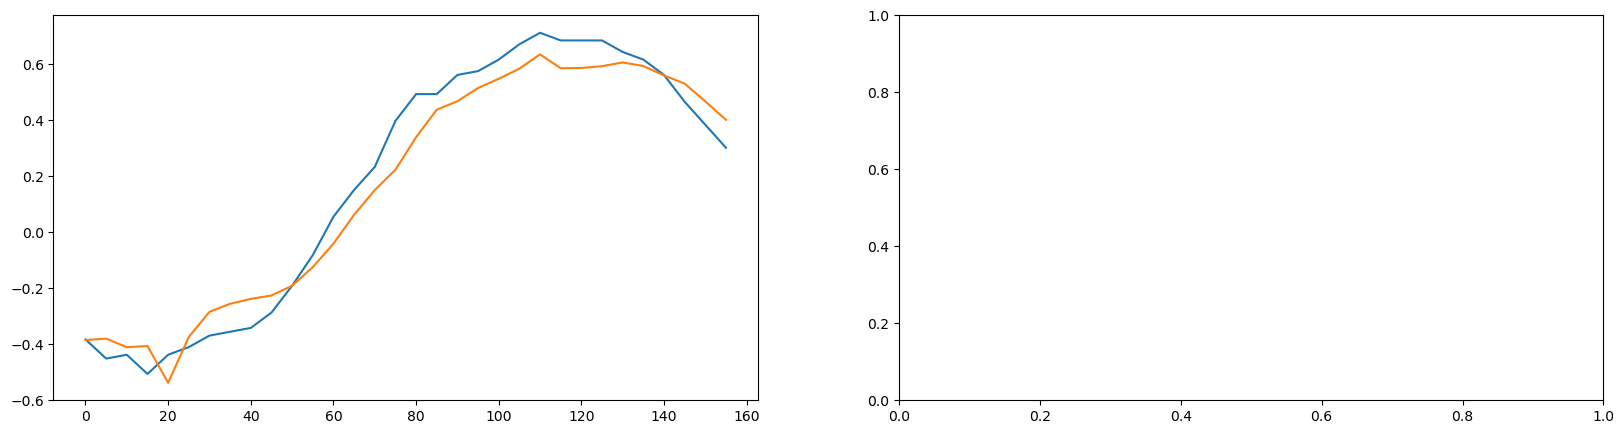

<Figure size 640x480 with 0 Axes>

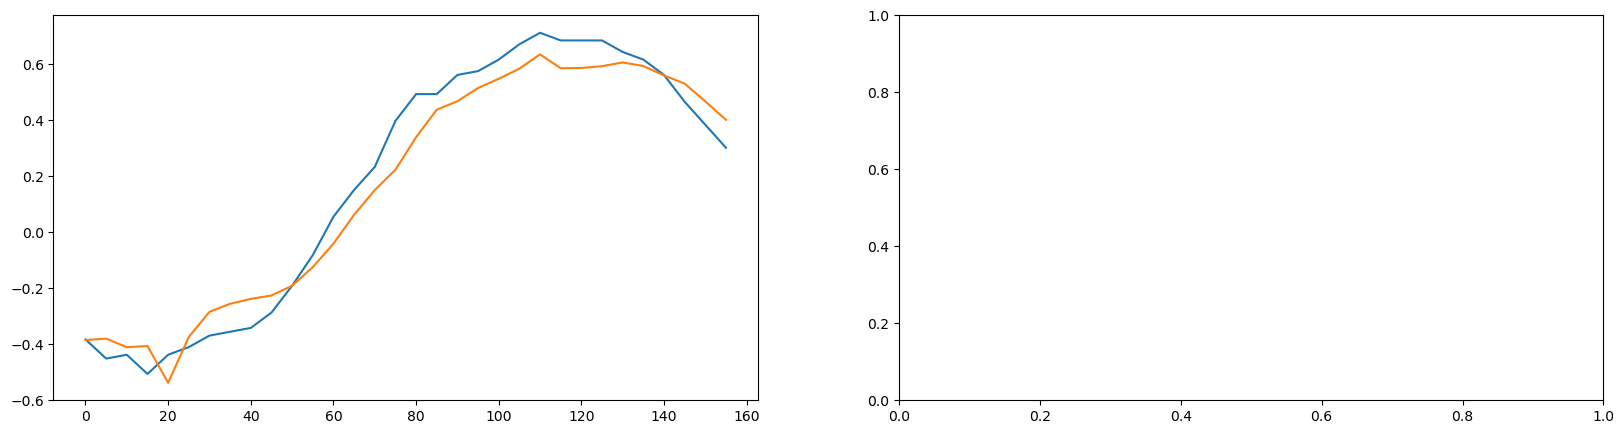

<Figure size 640x480 with 0 Axes>

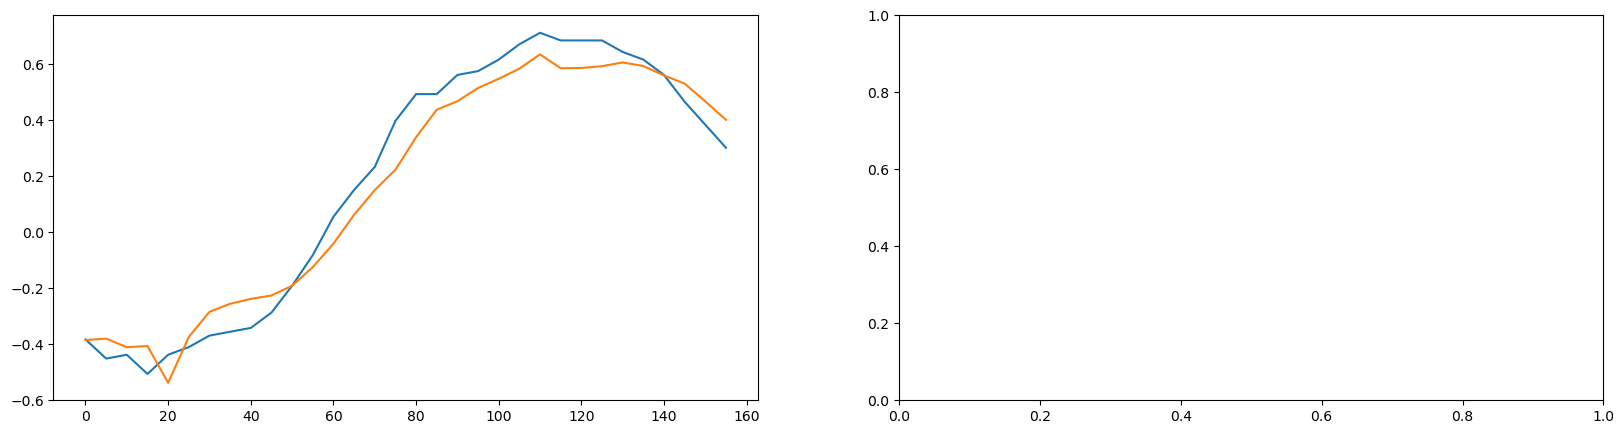

<Figure size 640x480 with 0 Axes>

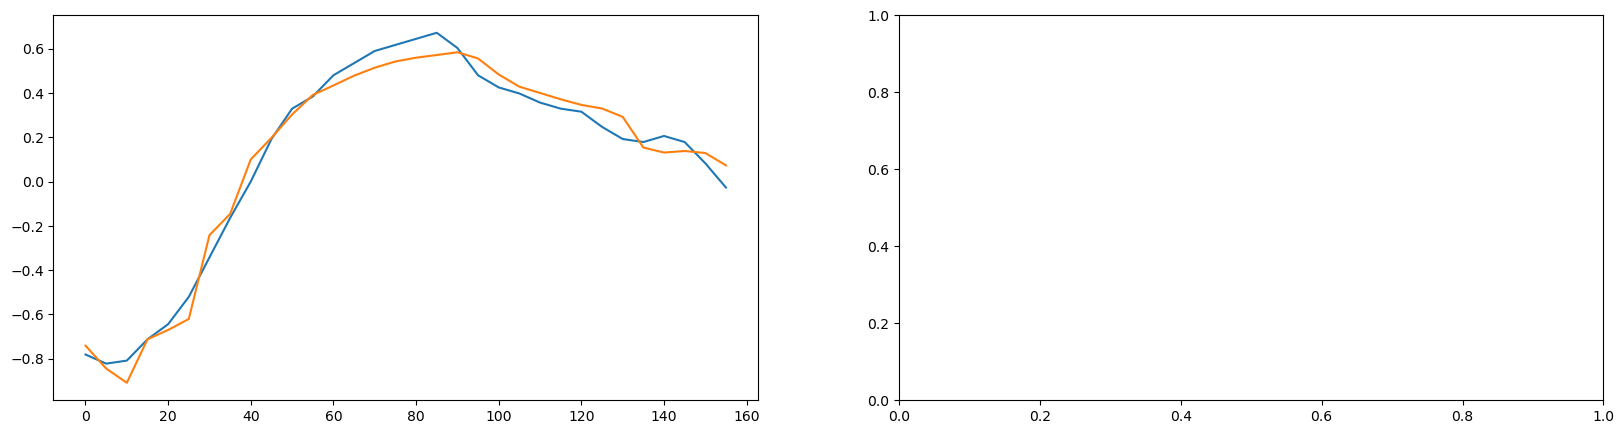

<Figure size 640x480 with 0 Axes>

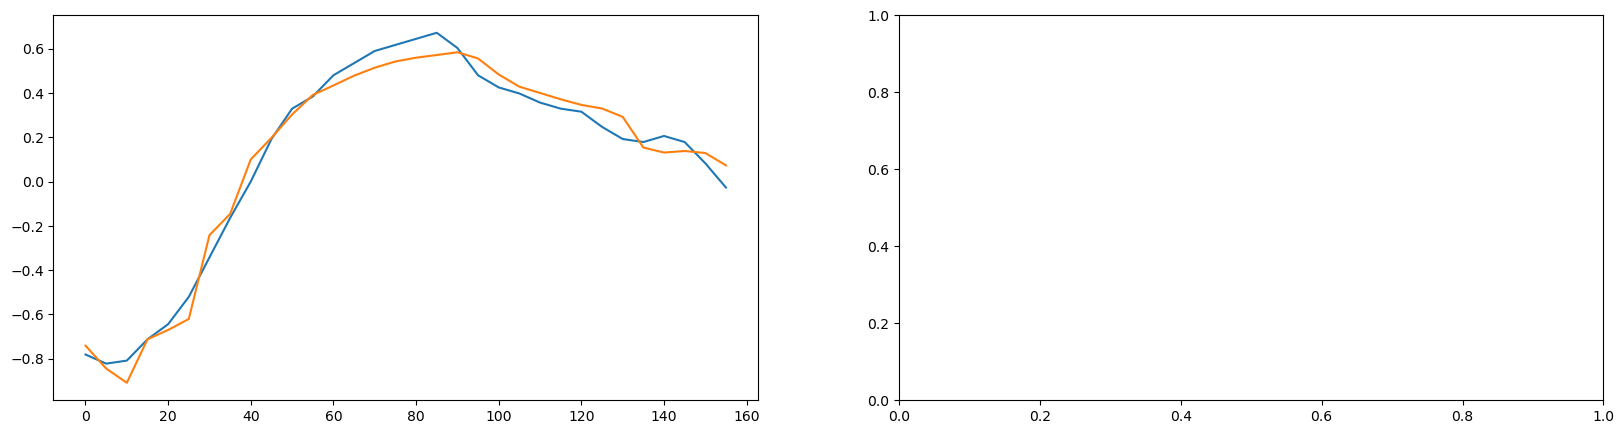

<Figure size 640x480 with 0 Axes>

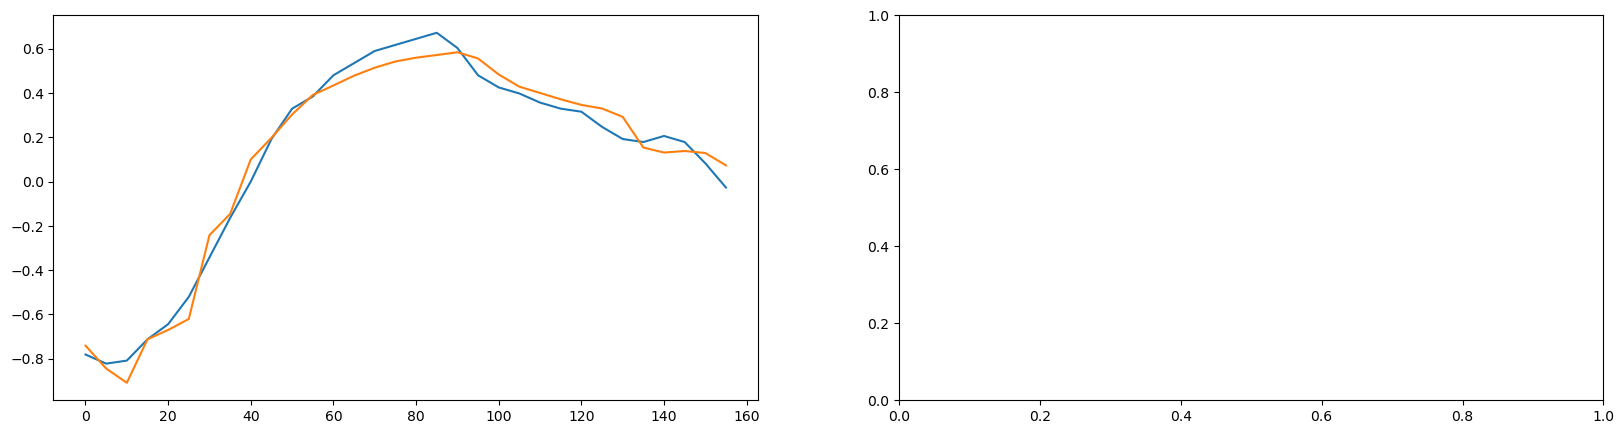

<Figure size 640x480 with 0 Axes>

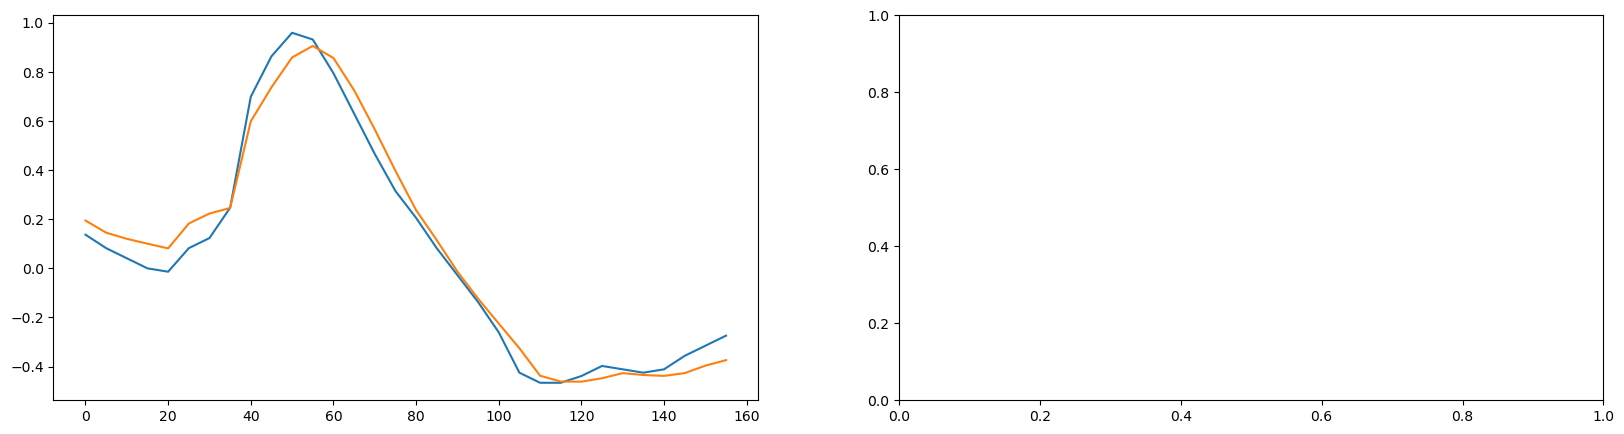

<Figure size 640x480 with 0 Axes>

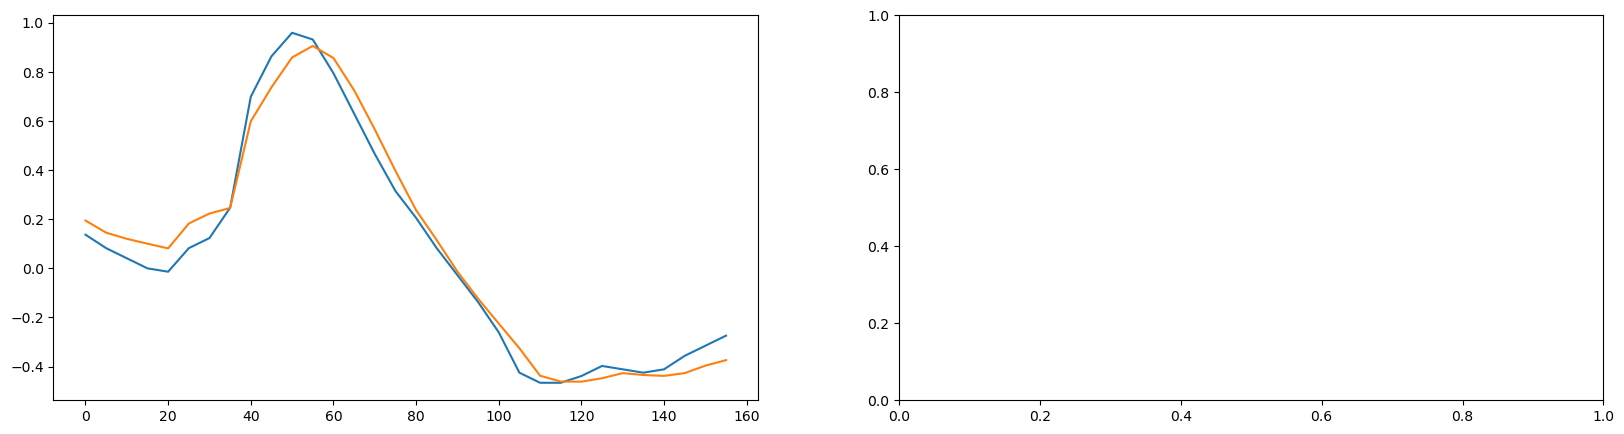

<Figure size 640x480 with 0 Axes>

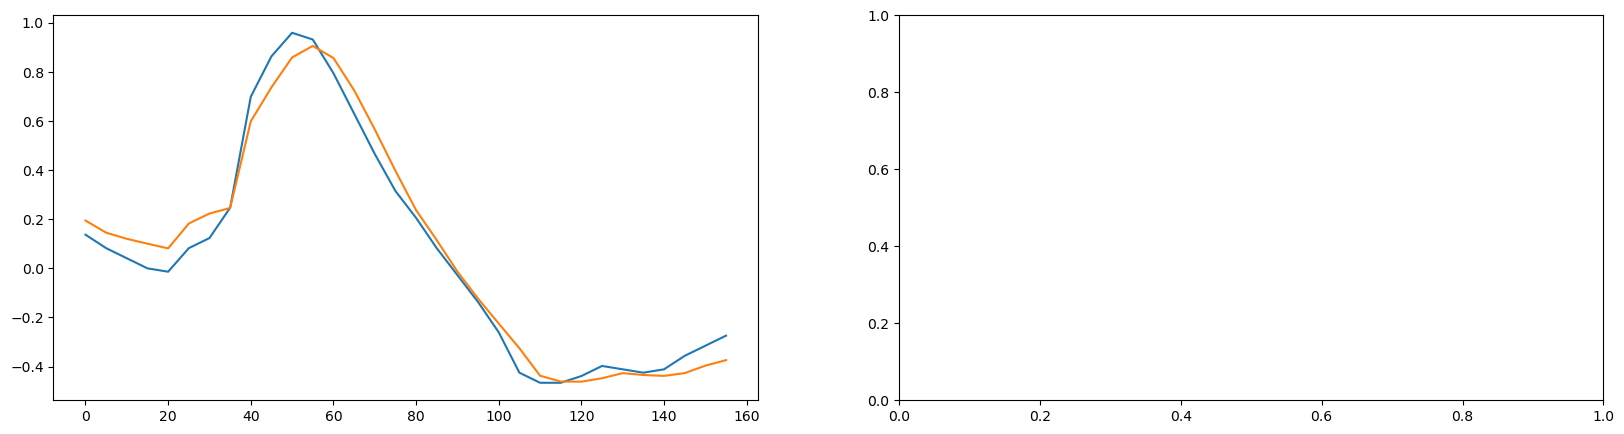

<Figure size 640x480 with 0 Axes>

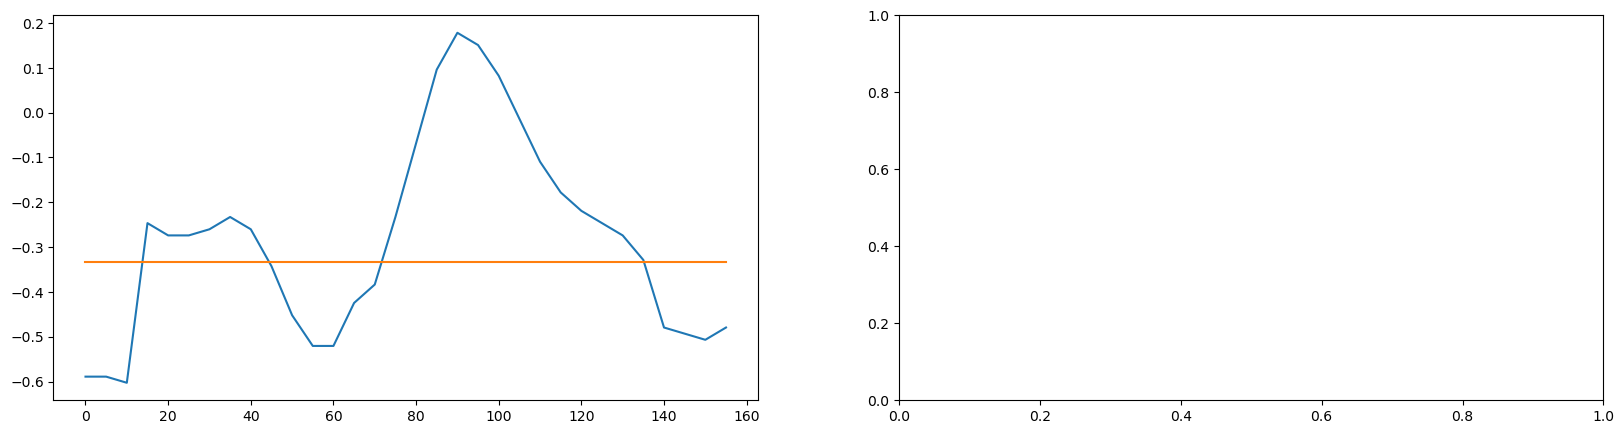

<Figure size 640x480 with 0 Axes>

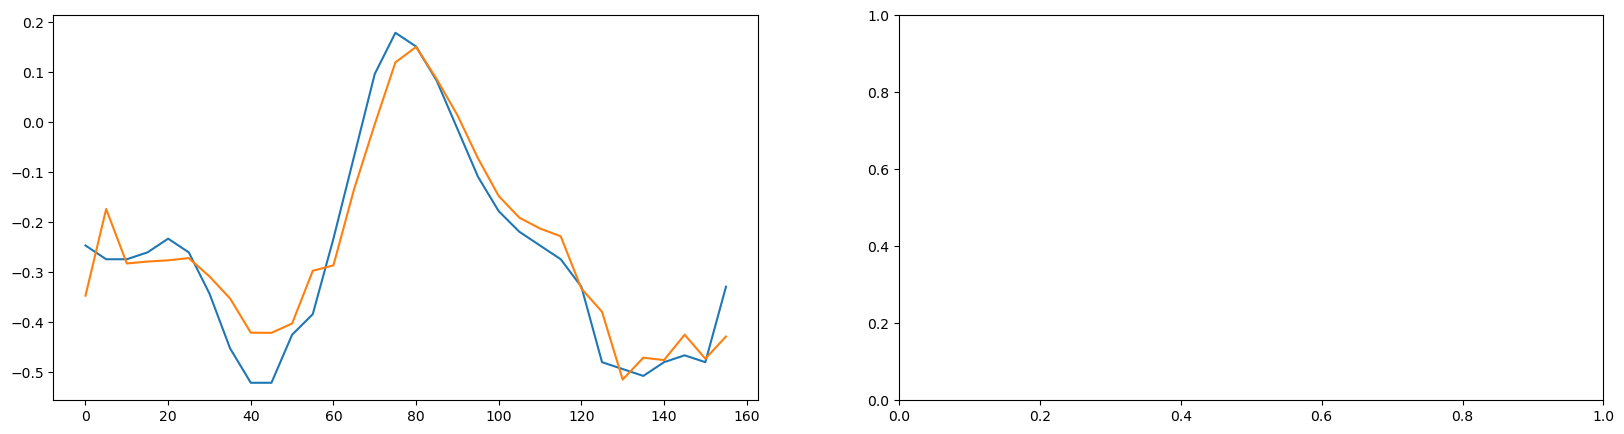

<Figure size 640x480 with 0 Axes>

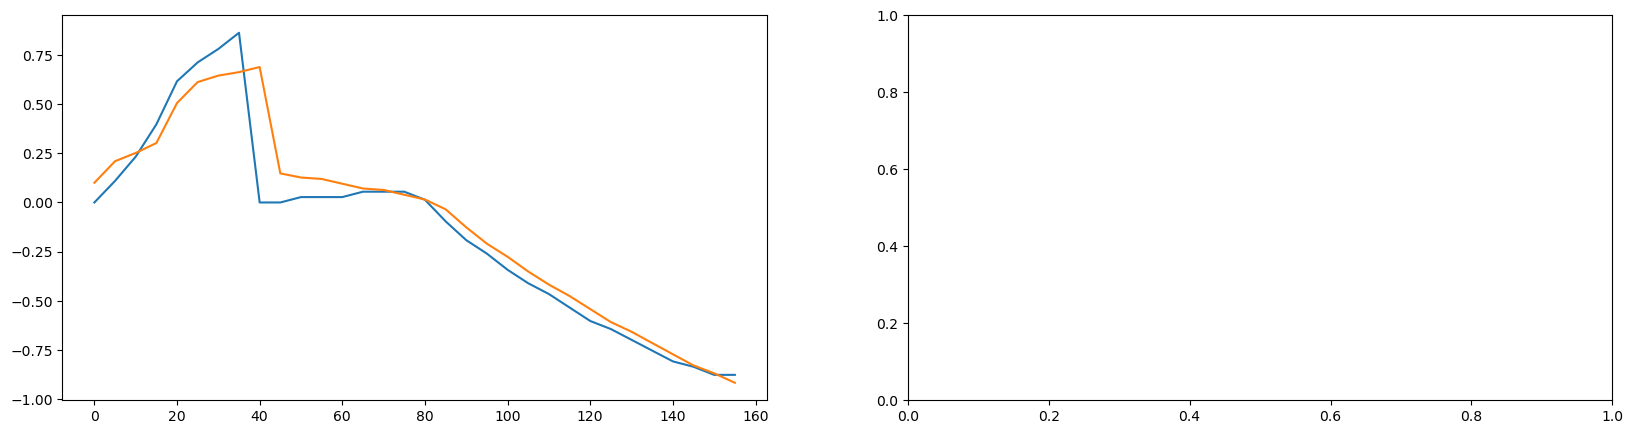

<Figure size 640x480 with 0 Axes>

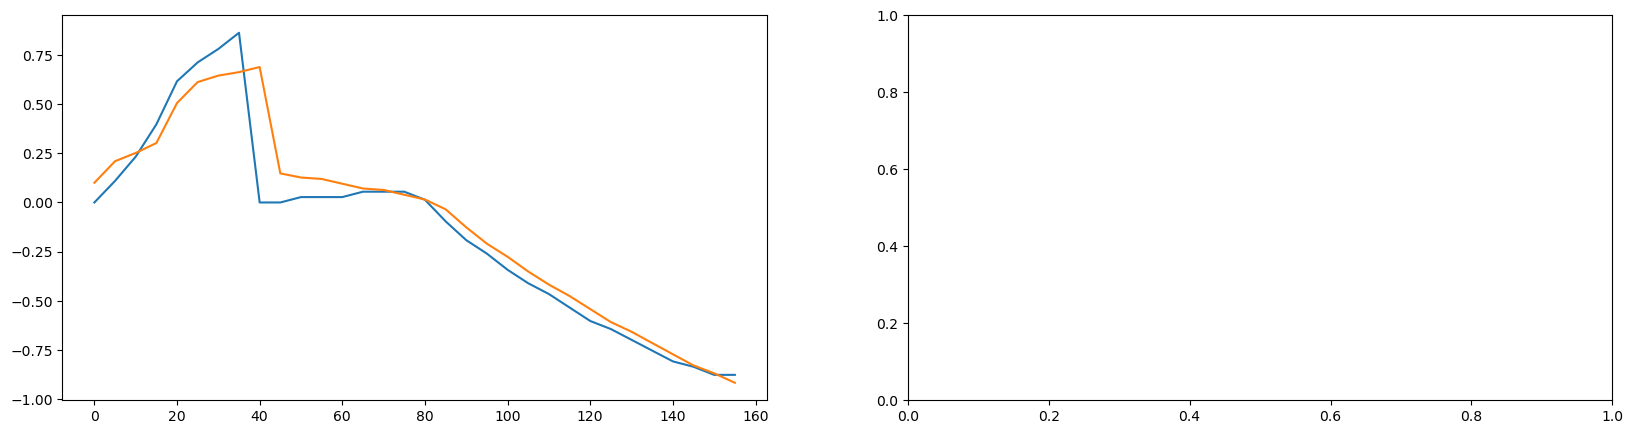

<Figure size 640x480 with 0 Axes>

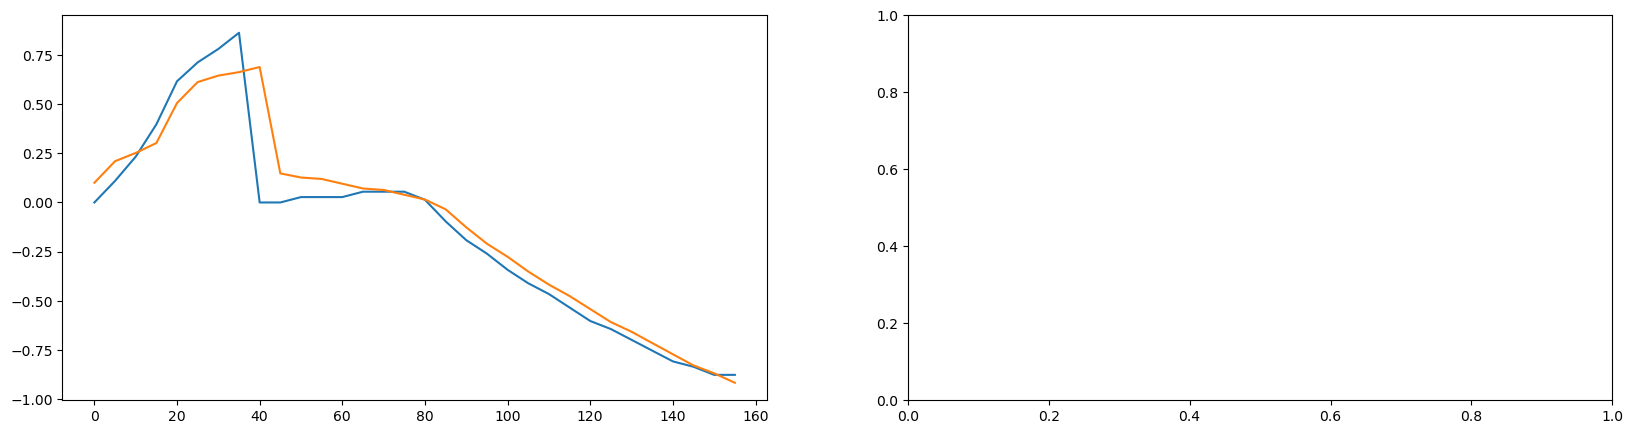

<Figure size 640x480 with 0 Axes>

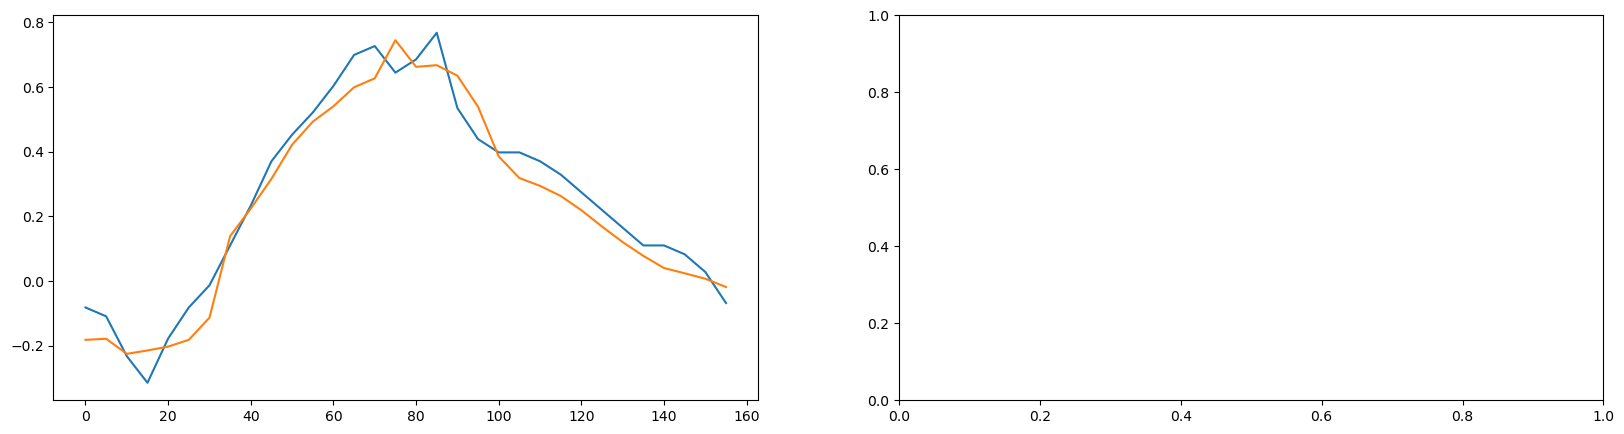

<Figure size 640x480 with 0 Axes>

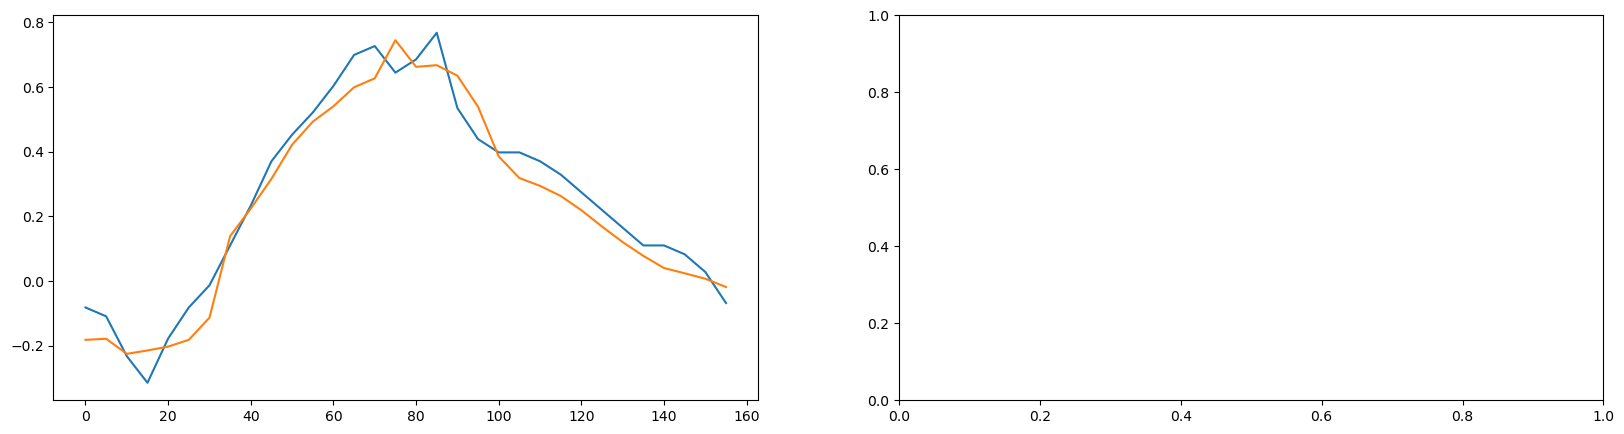

<Figure size 640x480 with 0 Axes>

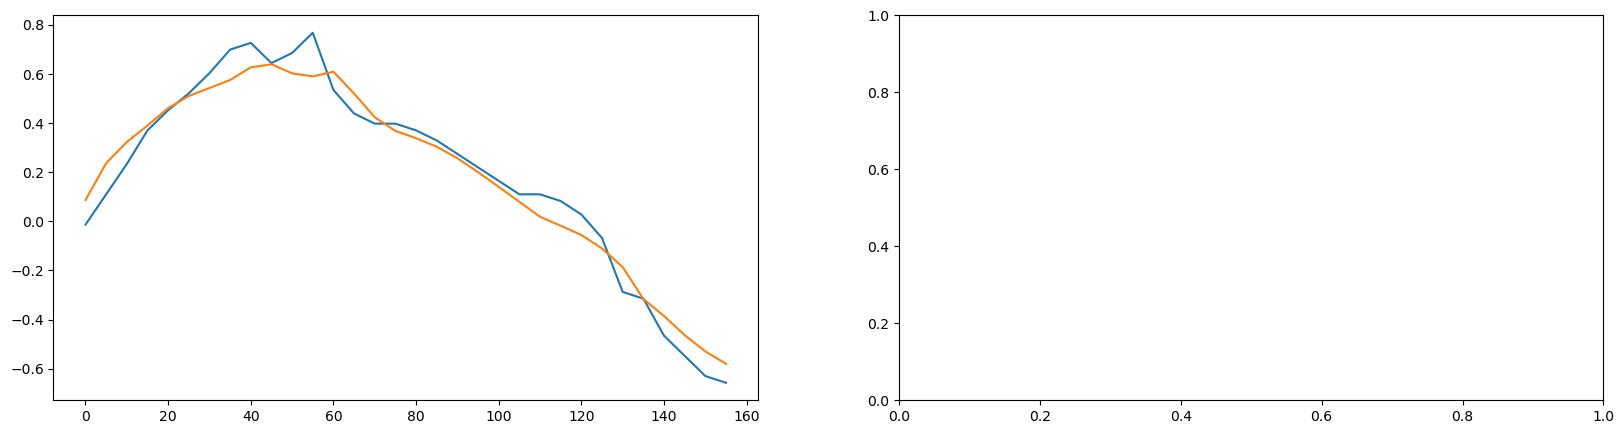

In [32]:
coef = []
model = SVR()
for i, data in enumerate(train_set):
    plt.figure()
    coef.append(train_model(model, data, i))

In [35]:
coef

[SVR(C=10, coef0=0.5, gamma='auto', kernel='sigmoid'),
 SVR(C=5, coef0=0.01, gamma='auto', kernel='sigmoid'),
 SVR(C=5, coef0=0.01, gamma='auto', kernel='sigmoid'),
 SVR(C=5, coef0=0.01, gamma='auto', kernel='sigmoid'),
 SVR(C=10, coef0=0.01, gamma='auto', kernel='sigmoid'),
 SVR(C=10, coef0=0.01, gamma='auto', kernel='sigmoid'),
 SVR(C=10, coef0=0.01, gamma='auto', kernel='sigmoid'),
 SVR(C=5, coef0=0.01),
 SVR(C=5, coef0=0.01),
 SVR(C=5, coef0=0.01),
 SVR(C=10, coef0=10, gamma='auto', kernel='sigmoid'),
 SVR(C=1, coef0=10, gamma='auto', kernel='poly'),
 SVR(C=5, coef0=0.01, gamma='auto', kernel='sigmoid'),
 SVR(C=5, coef0=0.01, gamma='auto', kernel='sigmoid'),
 SVR(C=5, coef0=0.01, gamma='auto', kernel='sigmoid'),
 SVR(C=1, coef0=0.5, degree=8, kernel='poly'),
 SVR(C=1, coef0=0.5, degree=8, kernel='poly'),
 SVR(C=1, coef0=0.01, gamma='auto')]

In [36]:
ensemble_model = SVR(C=5, coef0=0.01, gamma='auto', kernel='sigmoid')
for data in test_set:
    plt.figure()
    test_model(model, data, scaler)
    

NotFittedError: This SVR instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

<Figure size 640x480 with 0 Axes>